# Combines DEIMOS, vUDS, and HST spectra as well as observed and rest-frame photometric data in a plot to compare with simulated spectra for those galaxies.

In [1]:
%matplotlib inline
import numpy as np
import astropy
from astropy.io import ascii
from astropy.table import Table
from astropy.io import fits
from matplotlib import pyplot as plt
import os

Define names of files to be read into jupyter notebook

In [2]:
Data_overview_table_name = "DATA/gal_lib_short1.dat" #name of table which contains galaxy ID information and location for DEIMOS and vUDS spectra
DEIMOS_phot_name = 'DATA/cosmos_example_hostlib_spec.txt'#name of DEIMOS photometry file
vUDS_spec_location = "DATA/vUDS_spec/" #Note that this is the location of all of the vUDS spectrograph files, not the name of any in particular
DEIMOS_spec_location = 'DATA/cosmos_example_spectra/' #location of all of the DEIMOS spectrograph files
sim_spec_location = 'DATA/cosmos_example_spectra/' #location of all of the simulated spectra
HST_table_name = 'DATA/cosmos_match.dat' #name of table with HST ID information to locate and match spec files
HST_cosmos_folder_location = 'DATA/' #location of all cosmos tile folders (i.e. directory which contains cosmos-02, cosmos-03, etc.)

In [3]:
#Function which smooths flux (f) plots by taking the median for bins of N values each
medsmooth = lambda f, N : np.array([np.median(
    f[max(0,i-N):min(len(f),max(0,i-N)+2*N)]) for i in range(len(f))])

Read in ascii data table with DEIMOS and vUDS galaxy ID information and spectrograph file name/location information and text data table with photometric data for all DEIMOS galaxies

In [4]:
#Shortened table with relevant information for galaxy identification and spectrograph filenames (DEIMOS and vUDS)
#Null values are 0.0 or -999.99
T_dat = ascii.read(Data_overview_table_name)

#DEIMOS photometric data
F = np.genfromtxt(DEIMOS_phot_name, skip_header = 1)
T_phot = Table(names = ('IGNORE','GALID', 'RA_GAL', 'DEC_GAL', 'ZTRUE', 'ZERR', 'ZPHOT', 'ZPHOTERR', 'logsfr', 'logmass', 'logssfr', 'dssu_fit',  'sdssg_fit',  'sdssr_fit',  'sdssi_fit', 'sdssz_fit',  '2massj_fit',  '2massh_fit',  'hst_f606w_obs',  'hst_f814w_obs',  'hst_f125w_obs',  'hst_f140w_obs',  'hst_f160w_obs',  'wfirst_j129_obs',  'wfirst_h158_obs', 'n0_Sersic', 'a0_Sersic', 'b0_Sersic', 'a_rot', 'eazy_coeff00', 'eazy_coeff01', 'eazy_coeff02', 'eazy_coeff03', 'eazy_coeff04', 'eazy_coeff05', 'eazy_coeff06', 'eazy_coeff07', 'eazy_coeff08', 'eazy_coeff09', 'eazy_coeff10', 'eazy_coeff11', 'eazy_coeff12'))
for row in F:
    T_phot.add_row(row)
T_phot.remove_column('IGNORE')

In [5]:
phot_obs = [] #observed photometric data array
phot_obs_lam = [] #wavelengths corresponding to observed data
phot_rest = [] #rest-frame data array
phot_rest_lam = [] #wavelengths corresponding to rest-frame data
for i in range(len(T_phot["GALID"])):
    #rest-frame data
    data = [T_phot["sdssg_fit"][i], T_phot["sdssr_fit"][i], T_phot["sdssi_fit"][i], T_phot["sdssz_fit"][i], T_phot["2massj_fit"][i], T_phot["2massh_fit"][i]]
    phot_rest.append(data)
    #rest-frame wavelength
    z = T_phot["ZTRUE"][i]
    phot_rest_lam.append([4640*(1+z), 6580*(1+z), 8060*(1+z), 9000*(1+z), 12200*(1+z), 16300*(1+z)])
    
    #observed data
    dat = [T_phot["hst_f606w_obs"][i], T_phot["hst_f814w_obs"][i], T_phot["hst_f125w_obs"][i], T_phot["hst_f140w_obs"][i], T_phot["hst_f160w_obs"][i], T_phot["wfirst_j129_obs"][i], T_phot["wfirst_h158_obs"][i]]
    phot_obs.append(dat)
    #observed wavelength
    phot_obs_lam.append([5886, 8048, 12486,  13923, 15369, 12200, 16300])

Read in .fits files with vUDS spectra and DEIMOS spectra to collect wavelength and flux data

data_vUDS and data_DEIMOS, along with their corresponding wavelength arrays, are lists containing lists of flux and wavelength data. The indices of each array correspond to the same galaxy whose ID can be found in the GAL_ID array with the same index. If no spectrum is present, the position will be filled with a 0

In [6]:
#Collecting data for galaxies with DEIMOS and vUDS data
count = 0
data_vUDS = [] #vUDS spectrograph data
lam_vUDS = [] #wavelength for vUDS data
data_DEIMOS = [] #DEIMOS spectrograph data
lam_DEIMOS = [] #Wavelength for DEIMOS data
GAL_ID = [] #DEIMOS Galaxy ID
redshift = [] #Measured by DEIMOS
for i in range(len(T_dat['vUDS_spec_filename'])):
    if T_dat["vUDS_spec_filename"][i] != str(0):
        
        #opening vUDS file
        o = T_dat["vUDS_spec_filename"][i]
        F = fits.open(vUDS_spec_location+o)
        data_vUDS.append(F[0].data)
        
        #creating vUDS wavelength array
        lam_start = F[0].header['CRVAL1']
        lam_delt = F[0].header['CDELT1']
        lam_end = lam_start + lam_delt*(len(F[0].data))
        lam_vUDS.append(list(np.arange(lam_start, lam_end, lam_delt)))
        
    else:
        data_vUDS.append(0)
        lam_vUDS.append(0)
    #opening DEIMOS file
    GAL_ID.append(T_dat["GALID"][i])
    o = T_dat["DEIMOS_spec_filename"][i]
    F = fits.open(DEIMOS_spec_location+o)
    data_DEIMOS.append((F[1].data["FLUX"][0]))
    lam_DEIMOS.append((F[1].data['LAMBDA'][0]))
    redshift.append(T_dat["ZTRUE"][i])
    count = count + 1




Read in .fits files containing simulated spectra to collect their flux and wavelength data

In [7]:
sim_data = [] #Simulated DEIMOS spectra
sim_lam = [] #wavelength for simulated spectra
for i in range(len(T_dat['DEIMOS_spec_filename'])):
    galid = str(int(T_dat["GALID"][i]))
    F_sim = fits.open(sim_spec_location +'cosmos_example_host_simspec_'+galid+'.fits')
    T_sim = Table.read(F_sim)
    sim_data.append(list(T_sim["flux"]))
    sim_lam.append(list(T_sim['wave']))


Here, we are:
1. Smoothing the flux values to create spectra with less noise

2. Creating a list of AB mag data for each flux list (both for vUDS and DEIMOS, both smoothed and unsmoothed).
    Note: the AB mag lists will work in the same way as the flux lists in that they will contain lists of flux values. The indices will continue to match. If there is no flux data for a value (hence no AB mag), the place will be filled wih a 0.
        
3. Plotting the flux data

/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10


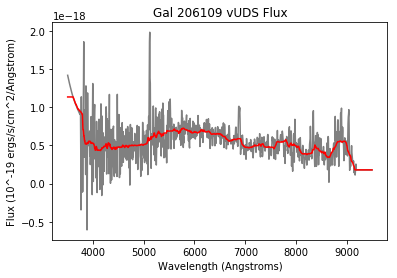

/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log10
/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log10


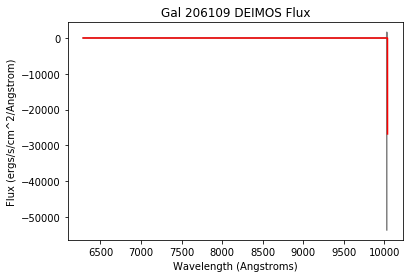

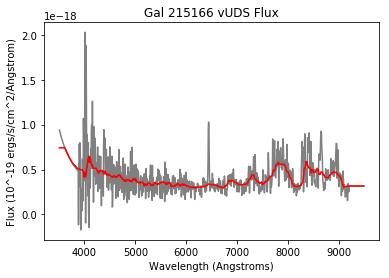

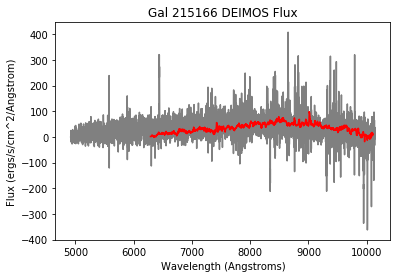

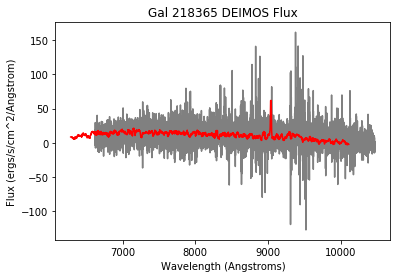

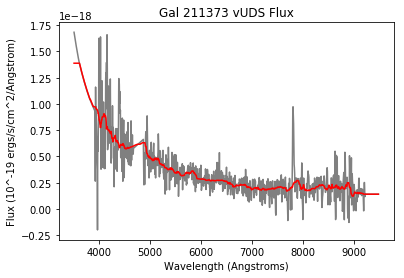

/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log10


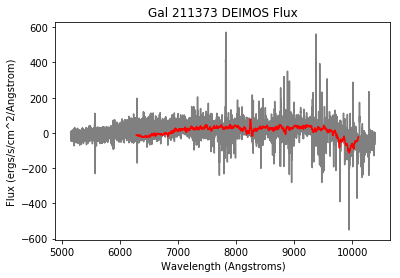

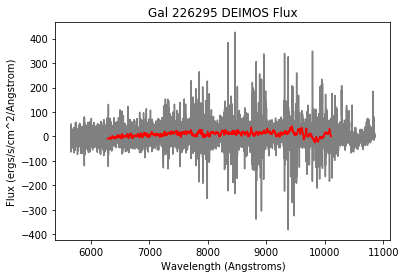

/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log10


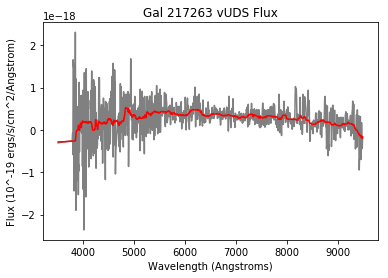

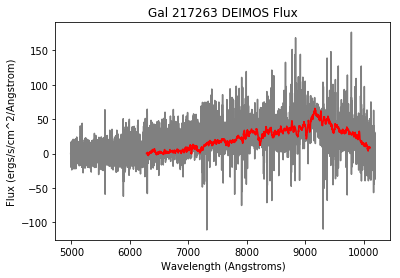

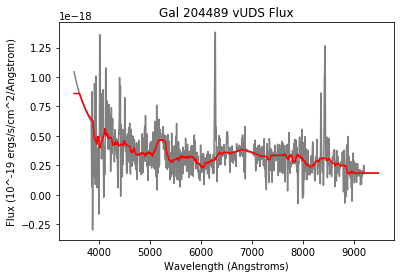

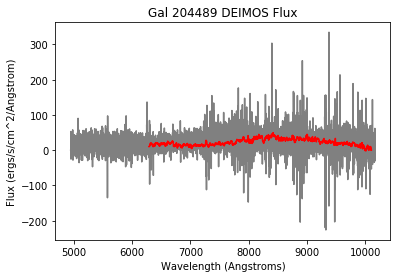

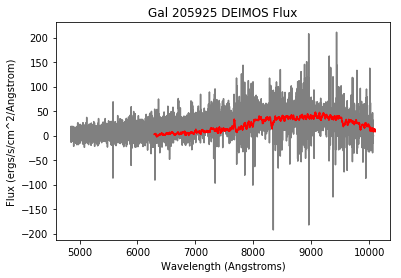

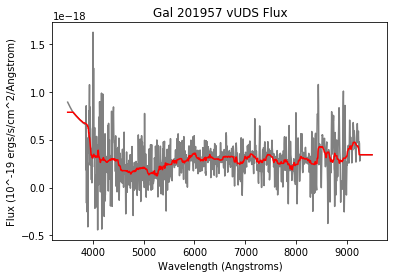

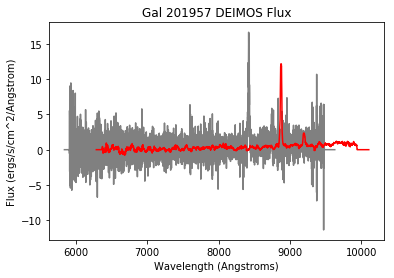

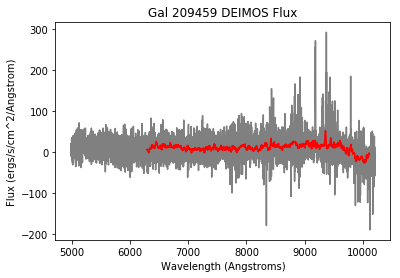

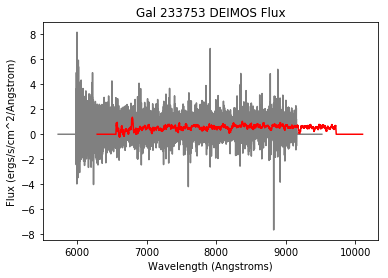

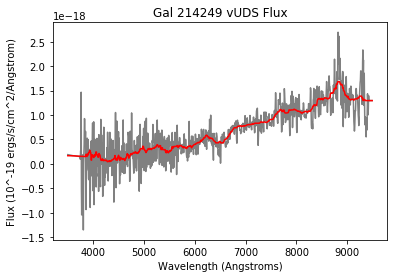

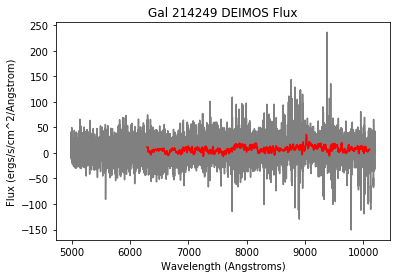

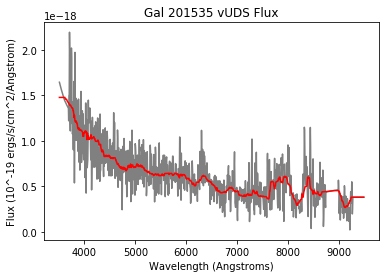

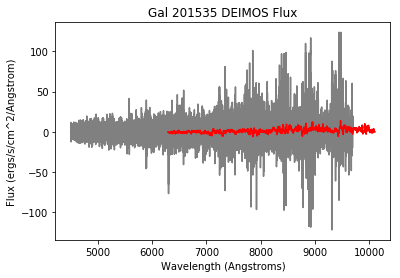

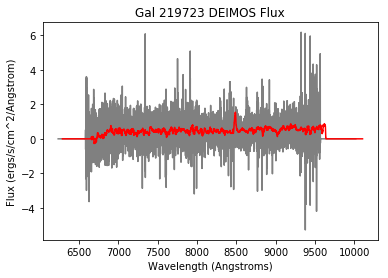

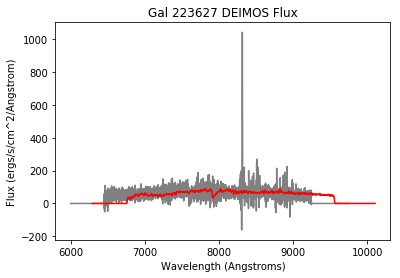

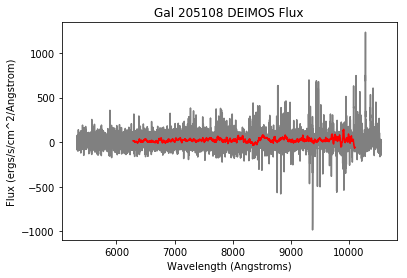

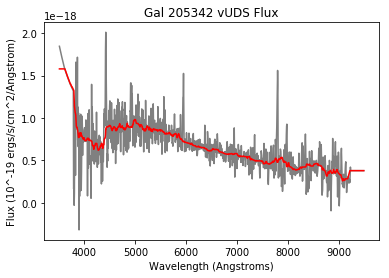

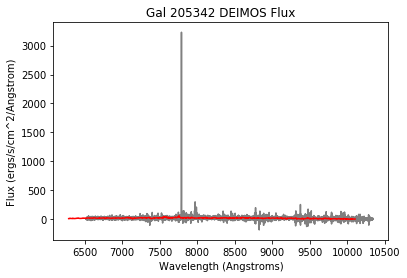

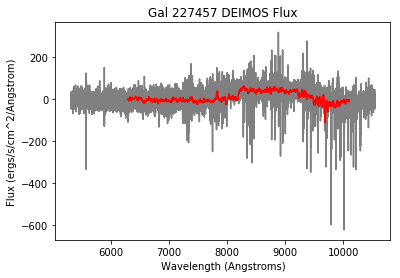

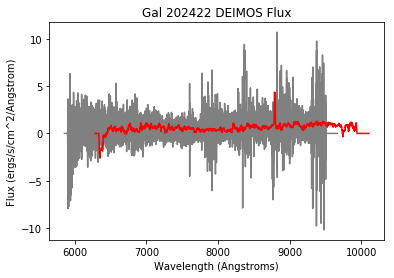

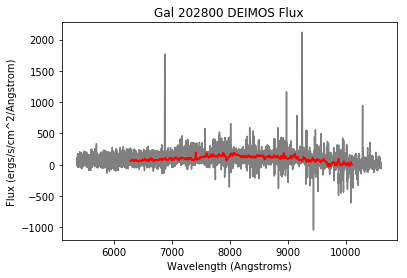

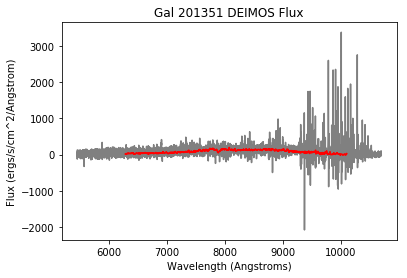

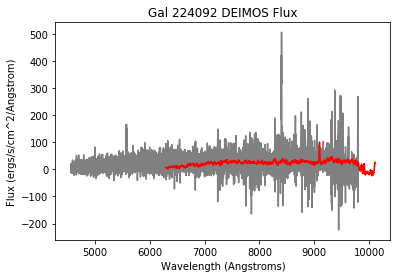

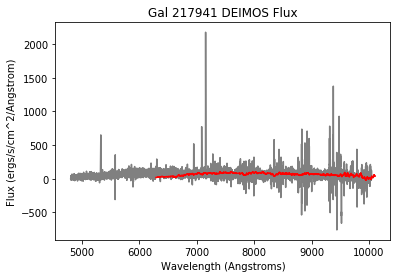

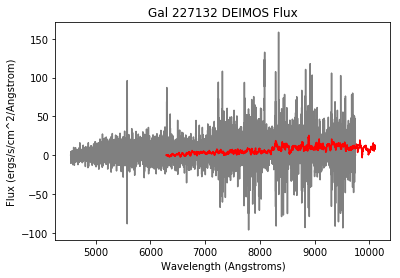

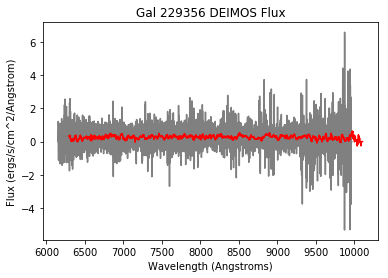

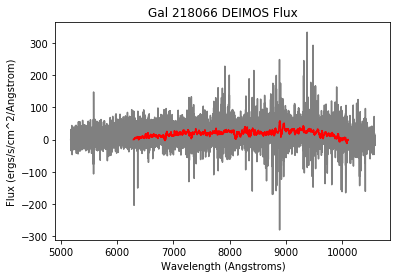

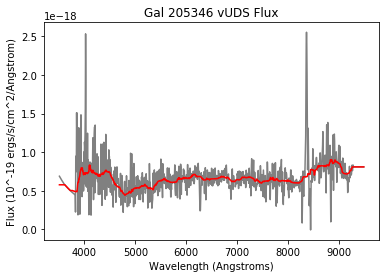

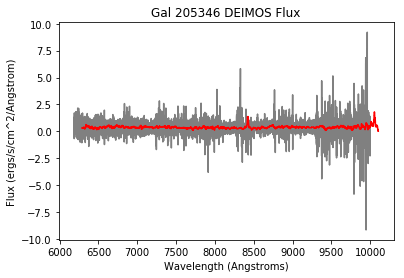

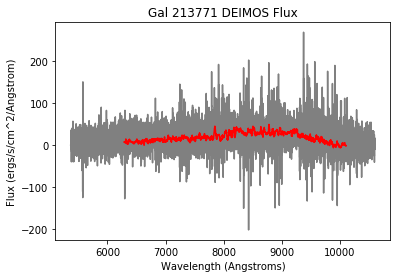

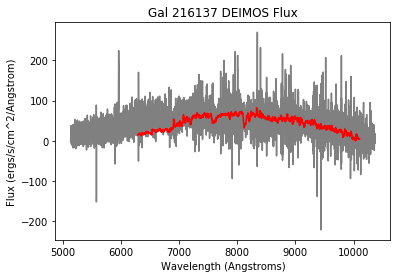

In [8]:
#Plotting flux from spectrograph files and finding their AB mag
mag_vUDS = [] #vUDS flux converted to AB mag
mag_mod_vUDS = [] #vUDS magnitude from smoothed flux
mag_DEIMOS = [] #DEIMOS flux converted to AB mag
mag_mod_DEIMOS = [] #DEIMOS magnitude from smoothed flux
lam_mod_vUDS_list = [] #vUDS wavelength for smoothed flux
lam_mod_DEIMOS_list = [] #DEIMOS wavelength for smoothed flux
data_mod_vUDS = [] #vUDS smoothed flux
data_mod_DEIMOS = [] #DEIMOS smoothed flux
mag_sim = [] #AB mag for simulated spectra
for x in range(count):
    #Each of these following ararys will contain data for the galaxy corresponding to that specific index.
    #They will be each appended onto the main arrays.
    mag_list_vUDS = []
    mag_mod_list_vUDS = []
    mag_list_DEIMOS = []
    mag_mod_list_DEIMOS = []
    sim_mag_list = []
    dat_DEIMOS = medsmooth(data_DEIMOS[x], 25) #array of smoothed DEIMOS flux
    data_mod_DEIMOS.append(dat_DEIMOS)
    
    if isinstance(data_vUDS[x], int) == False:
        dat_vUDS = medsmooth(data_vUDS[x], 20)
        lam_mod_vUDS = np.linspace(min(lam_vUDS[x]), max(lam_vUDS[x]), len(dat_vUDS))
        #converting from flux to AB mag for vUDS data
        for wave, flux in zip(lam_vUDS[x], data_vUDS[x]):
            m = -2.5 * np.log10(3.34e4 * wave * wave * (flux / 3631))
            mag_list_vUDS.append(m)
        #converting from flux to AB mag for smoothed vUDS data
        for wave, flux in zip(lam_mod_vUDS, dat_vUDS):
            m = -2.5 * np.log10(3.34e4 * wave * wave * (flux / 3631))
            mag_mod_list_vUDS.append(m)
        
        #Plotting vUDS flux data
        plt.plot(lam_vUDS[x], data_vUDS[x], color = 'grey') #original flux
        plt.plot(lam_mod_vUDS, dat_vUDS, color = 'r') #smoothed flux
        plt.title("Gal " + str(int(GAL_ID[x]))+ " vUDS Flux")
        plt.ylabel("Flux (10^-19 ergs/s/cm^2/Angstrom)")
        plt.xlabel("Wavelength (Angstroms)")
        plt.show()
    
    else:
        mag_list_vUDS = 0
        mag_mod_list_vUDS = 0
        dat_vUDS = 0
        lam_mod_vUDS = 0
    data_mod_vUDS.append(dat_vUDS)
    #flux to AB mag conversion for DEIMOS data
    lam_mod_DEIMOS = np.linspace(min(lam_DEIMOS[0]), max(lam_DEIMOS[0]), len(dat_DEIMOS))
    for wave, flux in zip(lam_DEIMOS[x], data_DEIMOS[x]):
        m = -2.5 * np.log10(3.34e4 * wave * wave * 10**(-19) *(flux / 3631))
        mag_list_DEIMOS.append(m)
    #flux to AB mag conversion for smoothed DEIMOS data
    for wave, flux in zip(lam_mod_DEIMOS, data_mod_DEIMOS[x]):
        m = -2.5 * np.log10(3.34e4 * wave * wave * 10**(-19) *(flux / 3631))
        mag_mod_list_DEIMOS.append(m)
    #flux to AB mag conversion for simulated data
    for wave, flux in zip(sim_lam[x], sim_data[x]):
        m = -2.5 * np.log10(3.34e4 * wave * wave * 10**(-19) *(flux / 3631))
        sim_mag_list.append(m)
    #Plotting DEIMOS flux data
    plt.plot(lam_DEIMOS[x], data_DEIMOS[x], color = 'grey') #original flux
    plt.plot(lam_mod_DEIMOS, data_mod_DEIMOS[x], color = 'r') #smoothed flux
    plt.title("Gal " + str(int(GAL_ID[x]))+ " DEIMOS Flux")
    plt.ylabel("Flux (ergs/s/cm^2/Angstrom)")
    plt.xlabel("Wavelength (Angstroms)")
    plt.show()
    #appending all of the lists for this galaxy onto the main arrays
    mag_vUDS.append(mag_list_vUDS) 
    mag_mod_vUDS.append(mag_mod_list_vUDS)
    lam_mod_vUDS_list.append(lam_mod_vUDS)
    mag_DEIMOS.append(mag_list_DEIMOS)
    mag_mod_DEIMOS.append(mag_mod_list_DEIMOS)
    mag_sim.append(sim_mag_list)
    lam_mod_DEIMOS_list.append(lam_mod_DEIMOS)
    

Plotting AB magintudes. If there is no data, the plot will be omitted.

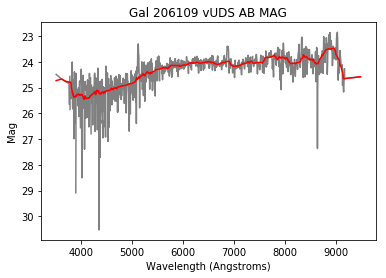

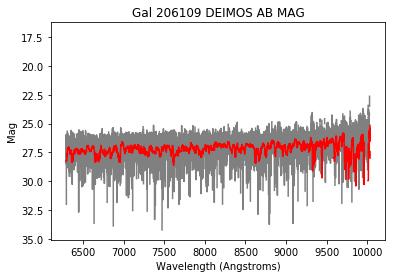

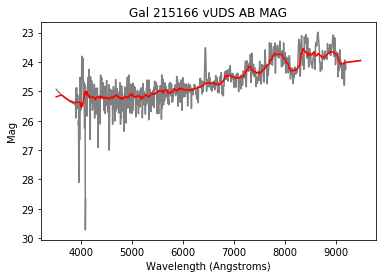

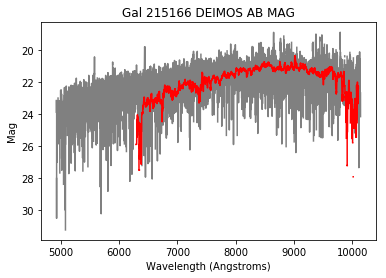

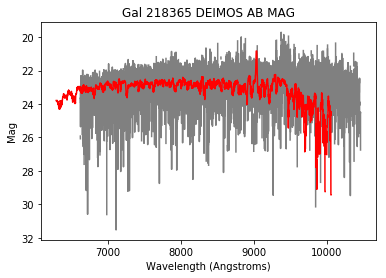

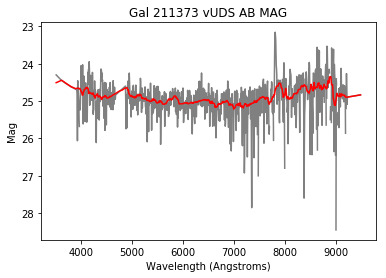

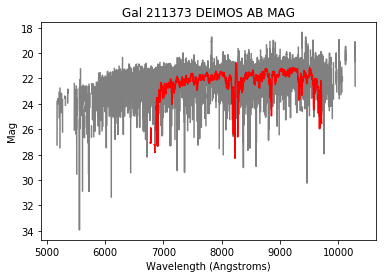

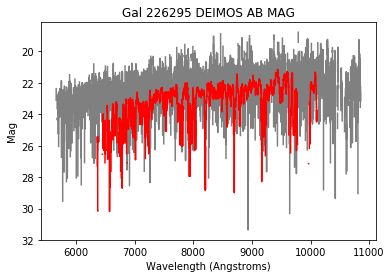

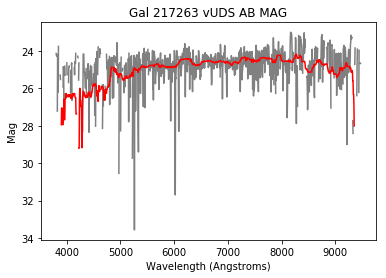

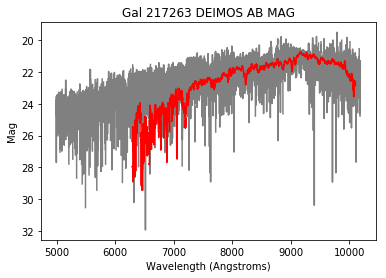

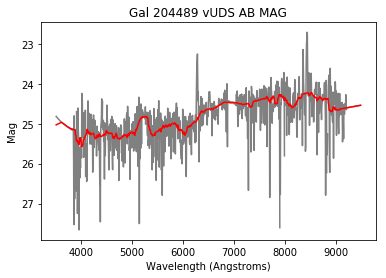

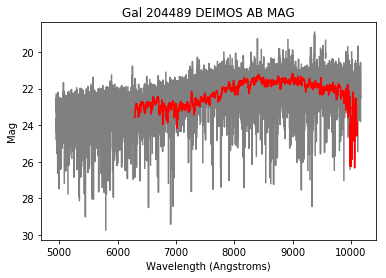

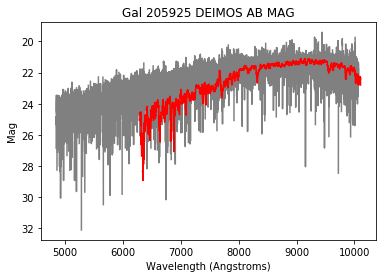

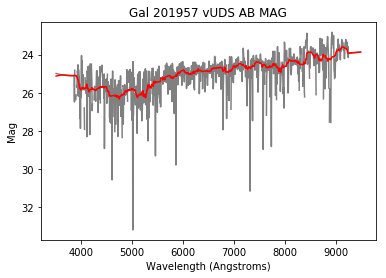

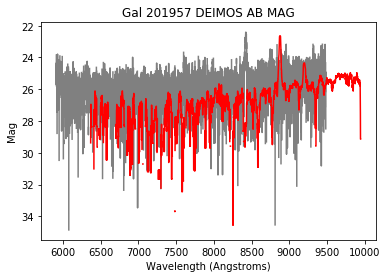

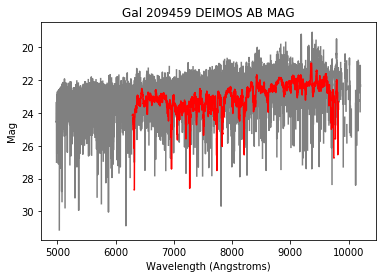

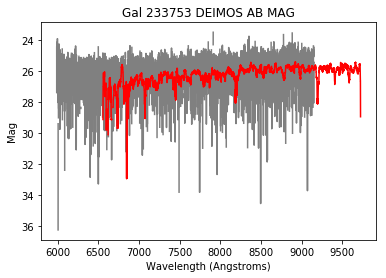

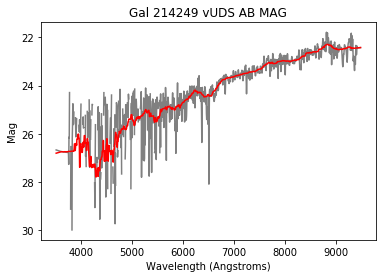

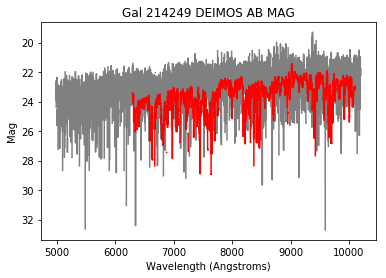

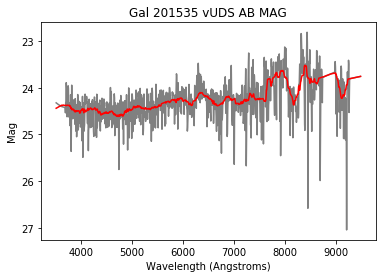

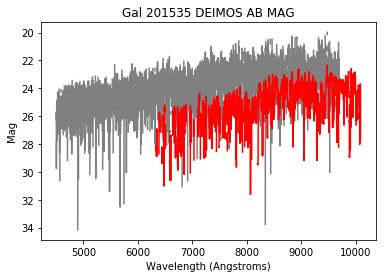

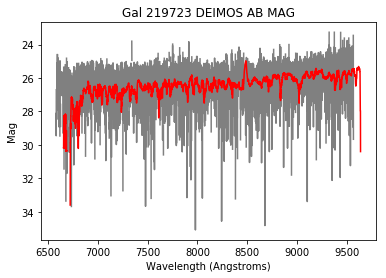

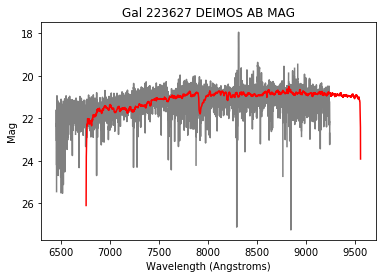

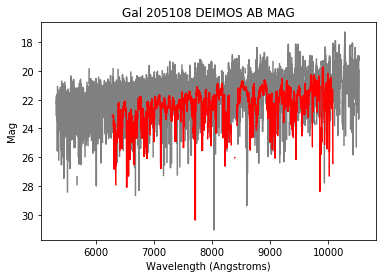

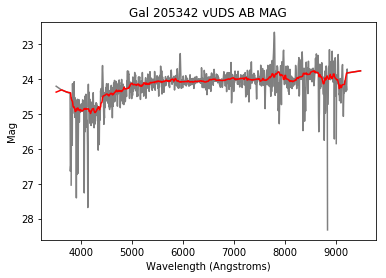

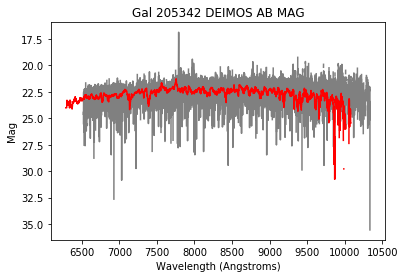

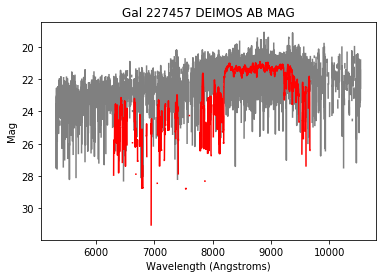

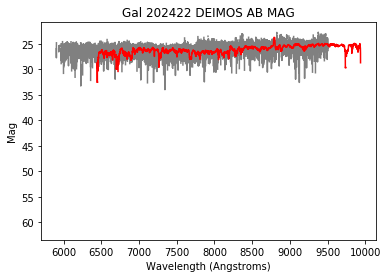

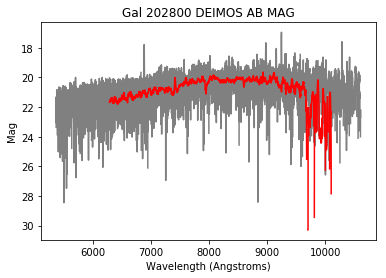

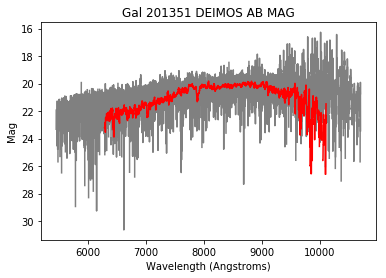

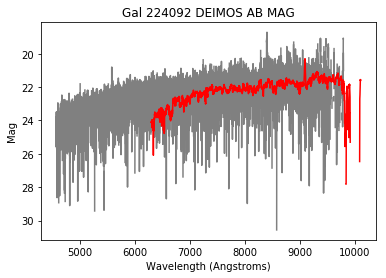

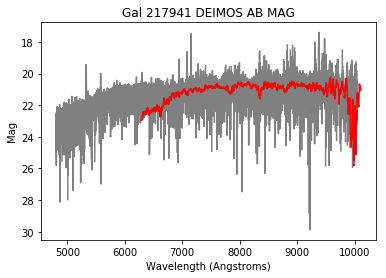

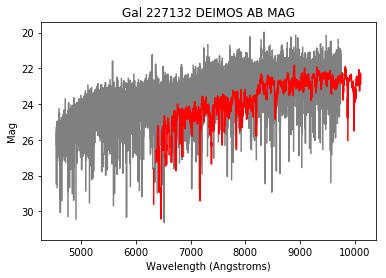

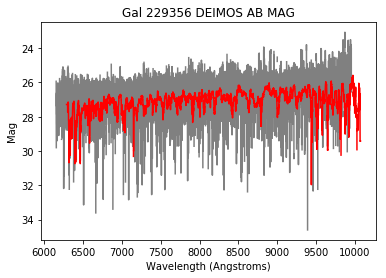

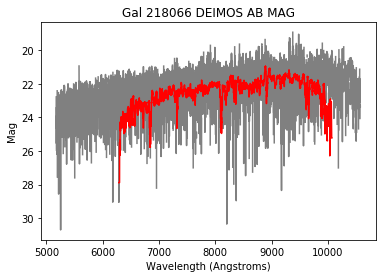

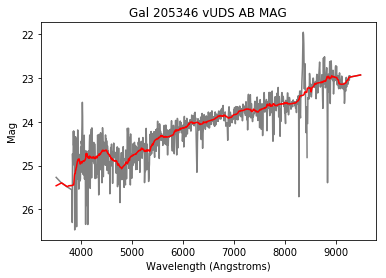

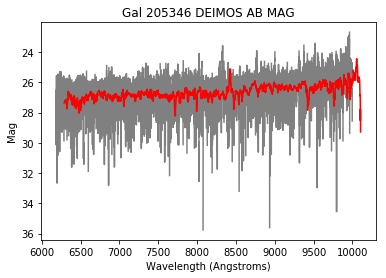

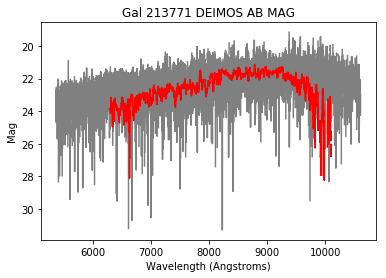

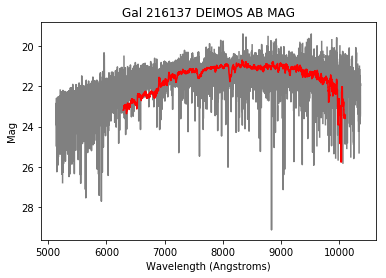

In [9]:
#Plotting AB magnitudes
for x in range(count):
    #vUDS data
    if isinstance(mag_vUDS[x], int) == False:
        plt.plot(lam_vUDS[x], mag_vUDS[x], color = 'grey') #original AB mag
        plt.plot(lam_mod_vUDS_list[x], mag_mod_vUDS[x], color = 'r') #AB mag from smoothed flux
        plt.title("Gal " + str(int(GAL_ID[x]))+ " vUDS AB MAG")
        plt.gca().invert_yaxis()
        plt.ylabel("Mag")
        plt.xlabel("Wavelength (Angstroms)")
        plt.show()
    #DEIMOS data
    plt.plot(lam_DEIMOS[x], mag_DEIMOS[x], color = 'grey') #original AB mag
    plt.plot(lam_mod_DEIMOS_list[x], mag_mod_DEIMOS[x], color = 'r') #smoothed AB mag
    plt.gca().invert_yaxis()
    plt.title("Gal " + str(int(GAL_ID[x]))+ " DEIMOS AB MAG")
    plt.ylabel("Mag")
    plt.xlabel("Wavelength (Angstroms)")
    plt.show()

Read in ascii file with HST data. Ensure that the data for each HST galaxy contains the corresponding DEIMOS galaxy ID in order to match the spectra for the correct galaxies. Both smoothed and unsmoothed flux arrays will be created. If no data is present, the place will be filled with a 0. If a file is not found or is unable to be read, the code will continue and return the name of the file below.

In [10]:
#adding HST data
data_HST = [] #HST flux
data_mod_HST = [] #smoothed HST flux
lam_HST = [] #HST wavelengths
lam_mod_HST_list = [] #HST wavelengths for smoothed data
for x in data_DEIMOS:
    data_HST.append(0)
    lam_HST.append(0)
    data_mod_HST.append(0)
    lam_mod_HST_list.append(0)
T_cosmos = ascii.read(HST_table_name)
for x in range(len(T_cosmos['id'])):
    #opening HST ascii file
    name = T_cosmos['id'][x]
    folder = T_cosmos['FOLDER'][x]
    name = int(name)
    if len(str(name)) == 4:
        filename = folder + '-G141_0' + str(name) +'.1D.ascii'
    else:
        filename = folder + '-G141_' + str(name) +'.1D.ascii'
    try:
        table = ascii.read(HST_cosmos_folder_location+folder+'/1D/ASCII/'+filename)
        for i in range(len(GAL_ID)):
            if GAL_ID[i] == T_cosmos["GALID"][x]: #ensuring that the same index corresponds to the same galaxy as the other data
                #gathering flux and wavelength data
                data_HST[i] = list(table["flux"])
                lam_HST[i] = list(table["wave"])
                #smoothing flux and creating corresponding wavelength array
                dat_HST = medsmooth(data_HST[i], 5)
                lam_mod_HST = np.linspace(min(lam_HST[i]), max(lam_HST[i]), len(dat_HST))
                data_mod_HST[i] = dat_HST
                lam_mod_HST_list[i] = lam_mod_HST
    except:
        print(filename + " not found")
    

cosmos-04-G141_16137.1D.ascii not found


Here, we are converting both smoothed and unsmoothed HST flux to AB mag and plotting the flux data. If there is no data, the place will be filled with a 0. 

/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/Users/leahvazsonyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


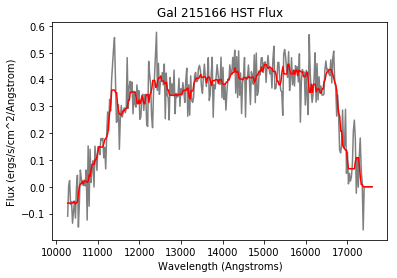

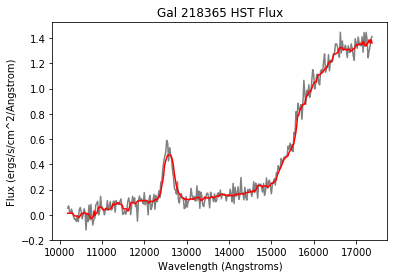

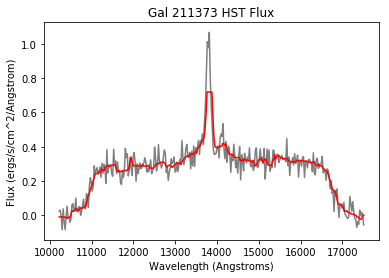

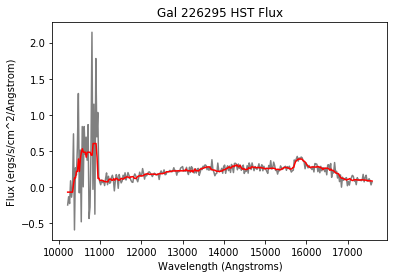

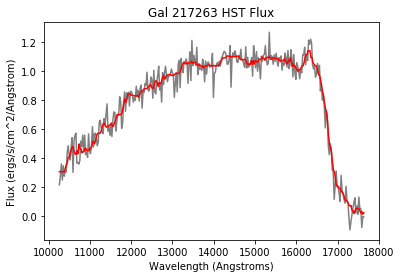

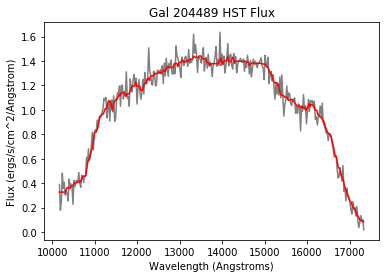

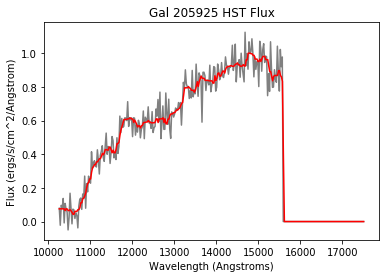

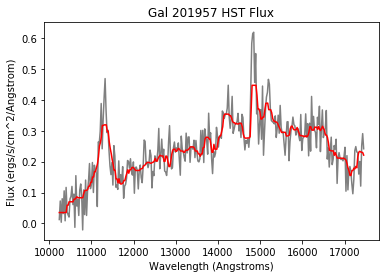

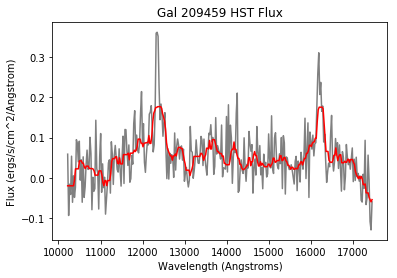

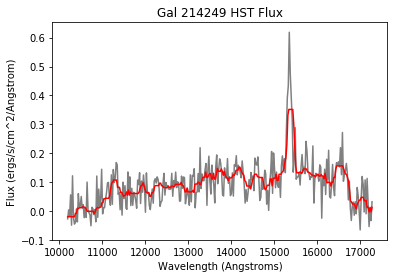

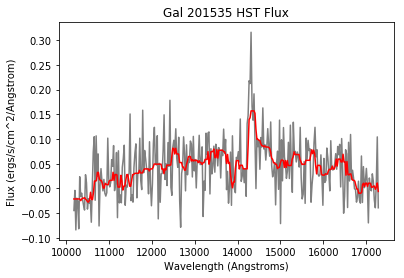

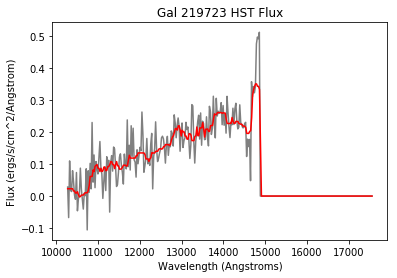

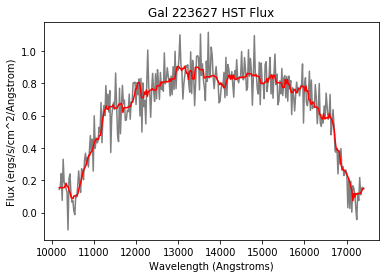

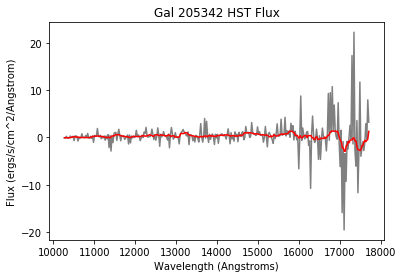

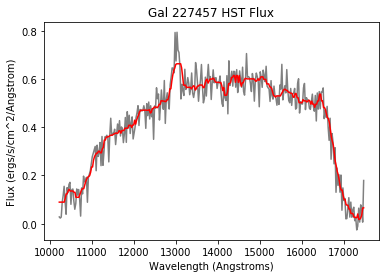

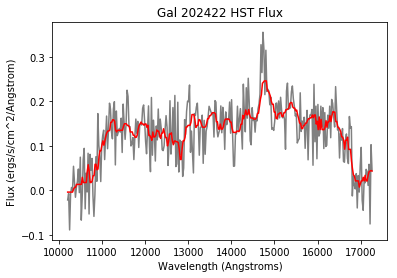

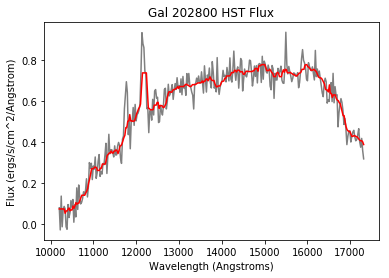

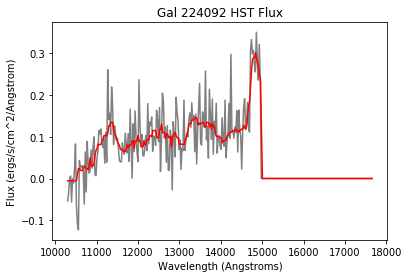

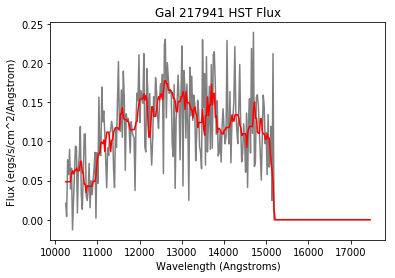

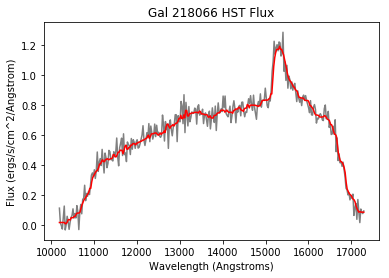

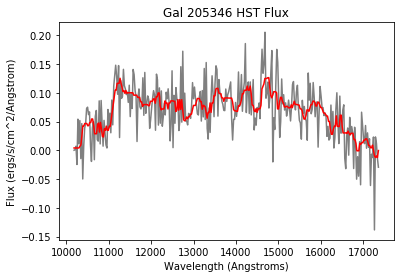

In [11]:
mag_HST = [] #HST data in AB mag
mag_mod_HST = [] #smoothed HST data in AB mag
for x in range(count):
    mag_HST.append(0)
    mag_mod_HST.append(0)
for x in range(count):
    if isinstance(data_HST[x], int) == False:
        mag_list_HST = []
        mag_mod_list_HST = []
        #converting from flux to AB mag for HST data
        for wave, flux in zip(lam_HST[x], data_HST[x]):
            m = -2.5 * np.log10(3.34e4 * wave * wave * 10**(-19)*(flux / 3631))
            #m = 25.0-2.5*np.log10(flux)
            mag_list_HST.append(m)
        #flux to AB mag for smoothed HST data
        for wave, flux in zip(lam_mod_HST_list[x], data_mod_HST[x]):
            m = -2.5 * np.log10(3.34e4 * wave * wave * 10**(-19)*(flux / 3631))
            #m = 25.0-2.5*np.log10(flux)
            mag_mod_list_HST.append(m)
            
    #Plotting HST flux data
        plt.plot(lam_HST[x], data_HST[x], color = 'grey') #original flux
        plt.plot(lam_mod_HST_list[x], data_mod_HST[x], color = 'r') #smoothed flux
        plt.title("Gal " + str(int(GAL_ID[x]))+ " HST Flux")
        plt.ylabel("Flux (ergs/s/cm^2/Angstrom)")
        plt.xlabel("Wavelength (Angstroms)")
        plt.show()
        mag_HST[x] = (mag_list_HST) 
        mag_mod_HST[x] = mag_mod_list_HST

Plotting HST AB mag data

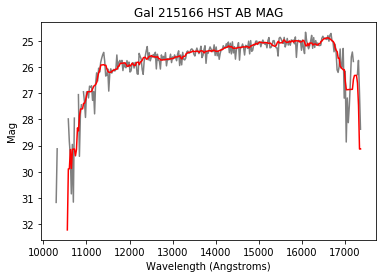

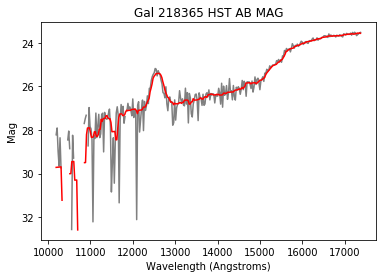

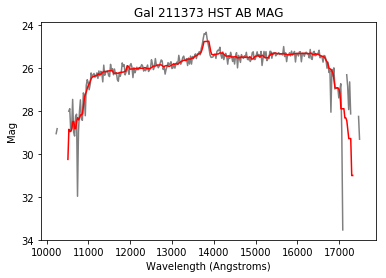

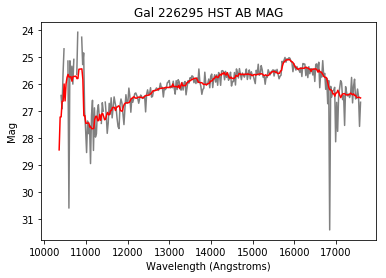

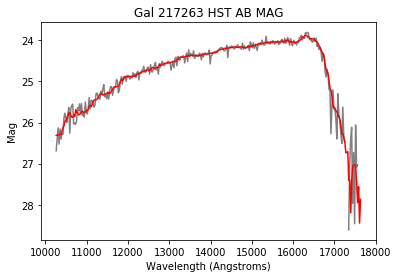

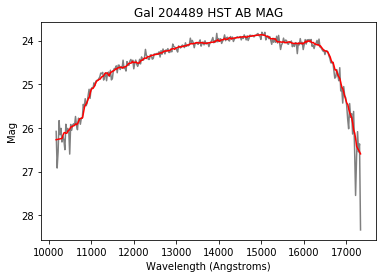

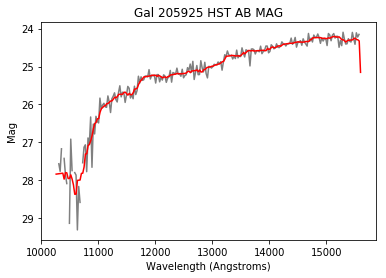

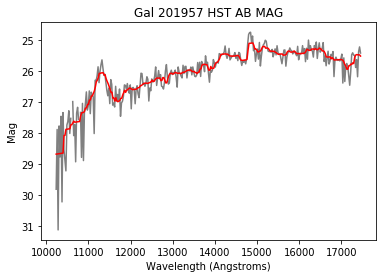

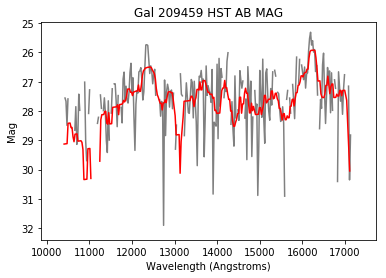

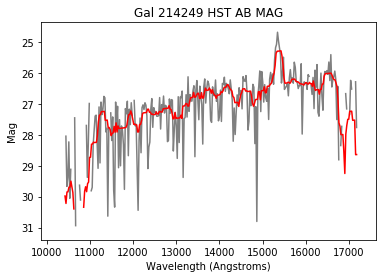

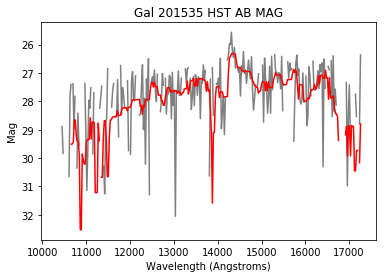

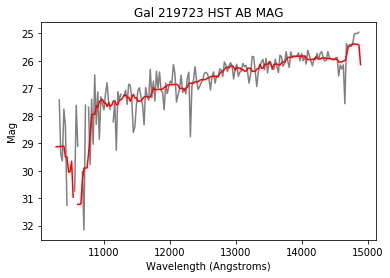

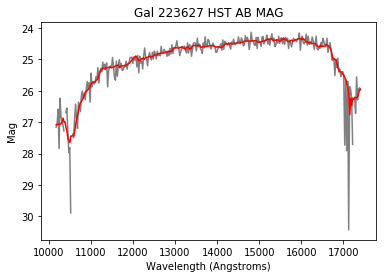

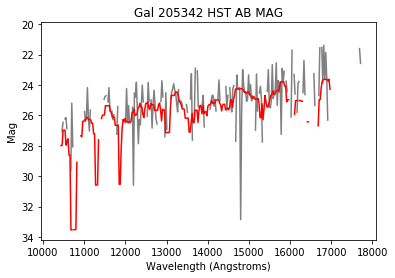

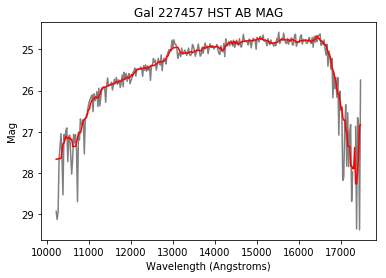

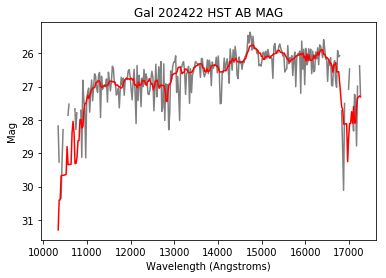

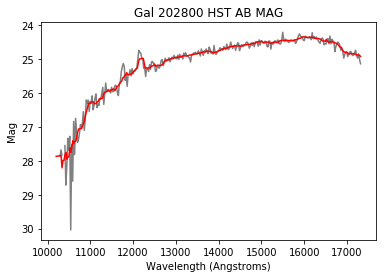

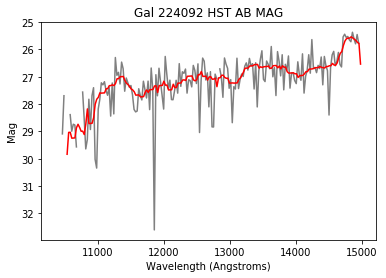

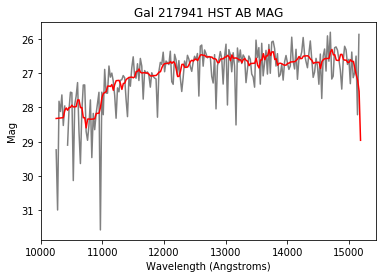

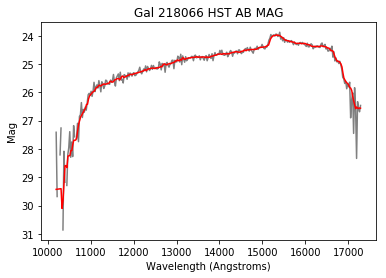

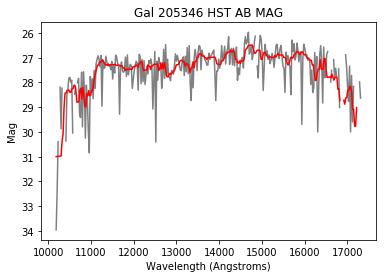

In [12]:
for x in range(count):
    if isinstance(mag_HST[x], int) == False:
        plt.plot(lam_HST[x], mag_HST[x], color = 'grey') #orignal HST AB mag
        plt.plot(lam_mod_HST_list[x], mag_mod_HST[x], color = 'r') #smoothed HST AB mag
        plt.title("Gal " + str(int(GAL_ID[x]))+ " HST AB MAG")
        plt.gca().invert_yaxis()
        plt.ylabel("Mag")
        plt.xlabel("Wavelength (Angstroms)")
        plt.show()

Combining all of the different smoothed AB mag plots to see whether they align properly and check simulated spectrum. The plots will be exported to a directory called spec_plotting_test_output. If there is no data from one of the sources, the plot will be omitted.

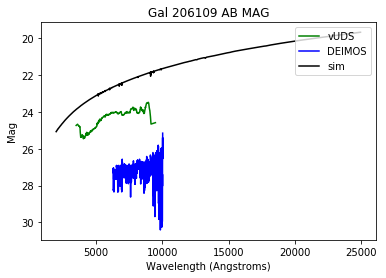

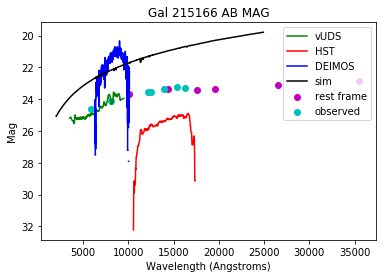

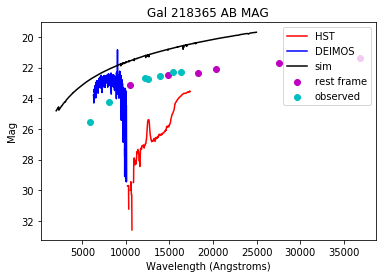

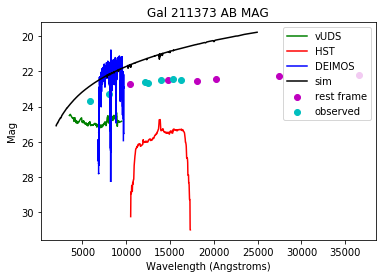

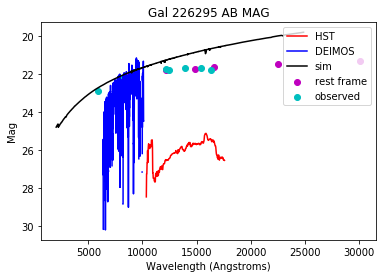

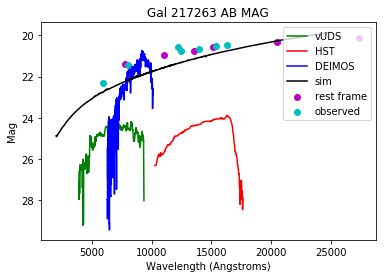

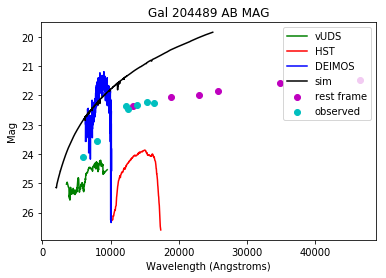

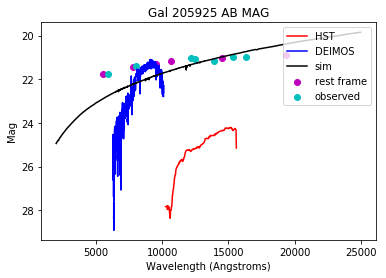

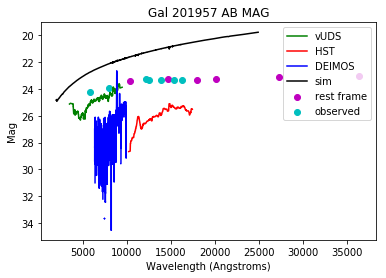

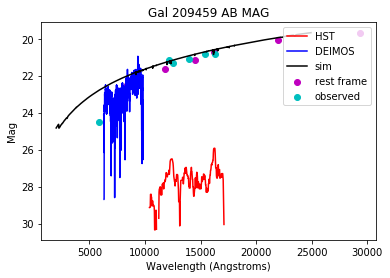

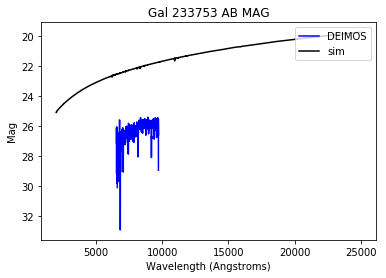

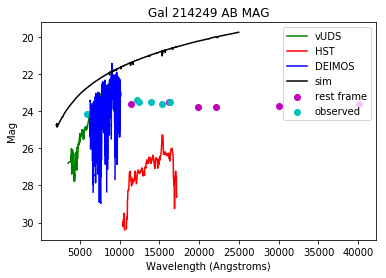

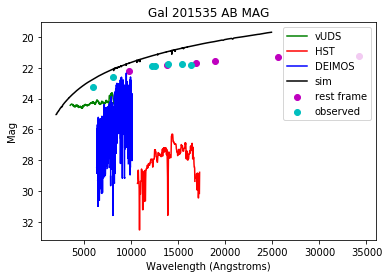

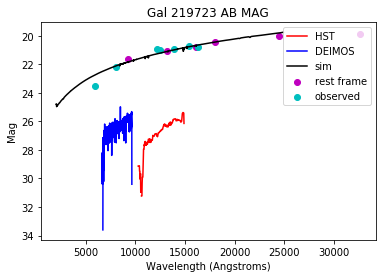

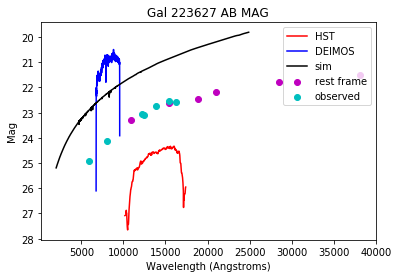

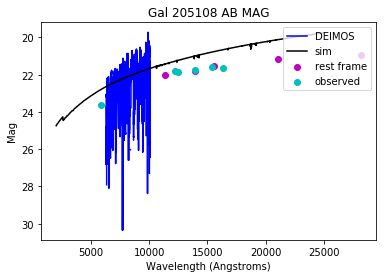

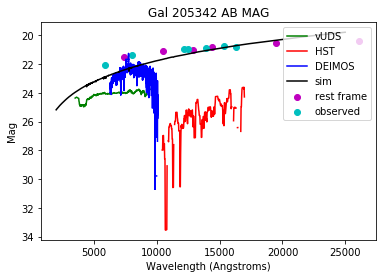

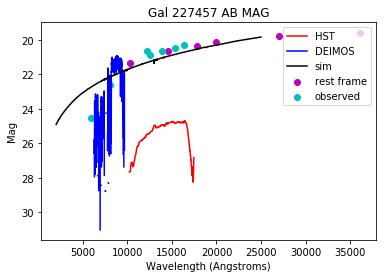

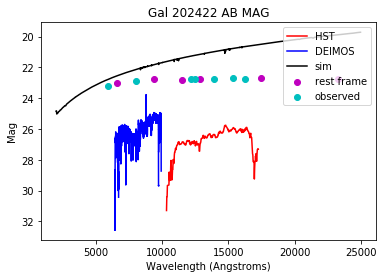

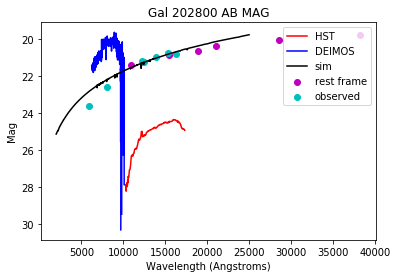

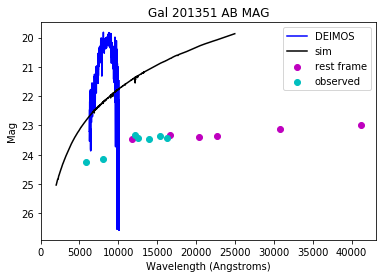

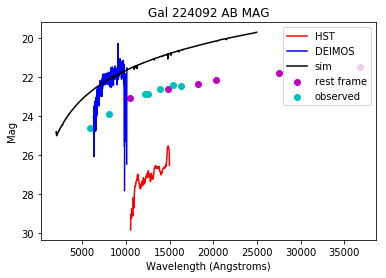

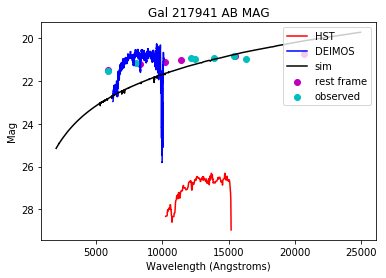

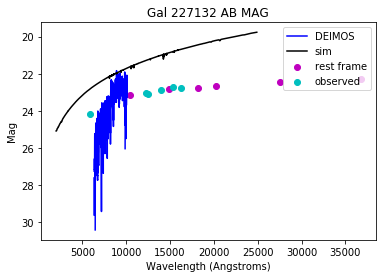

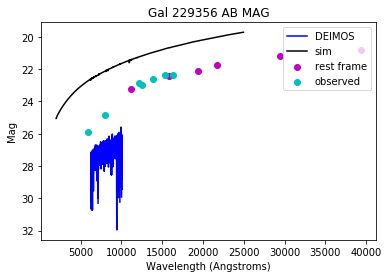

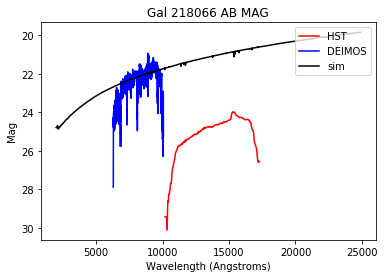

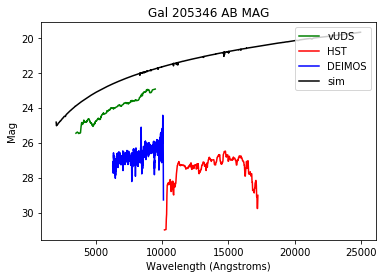

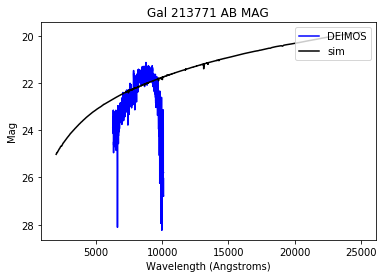

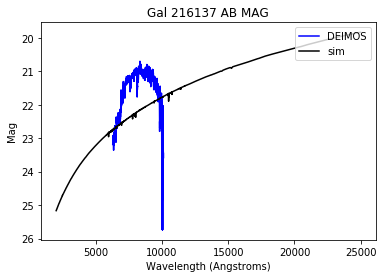

<Figure size 432x288 with 0 Axes>

In [13]:
#Plotting AB magnitudes
for x in range(count):
    #vUDS plot
    if isinstance(mag_mod_vUDS[x], int) == False:
        plt.plot(lam_mod_vUDS_list[x], mag_mod_vUDS[x], color = 'g', label = 'vUDS')
    #HST plot
    if isinstance(mag_HST[x], int) == False:
        plt.plot(lam_mod_HST_list[x], mag_mod_HST[x], color = 'r', label = 'HST')
    if -999 not in phot_obs[x]:
        #rest-frame photometry
        plt.scatter(phot_rest_lam[x], phot_rest[x], color = 'm', label = 'rest frame')
        #observed photometry
        plt.scatter(phot_obs_lam[x], phot_obs[x], color = 'c', label = 'observed')
        
    #DEIMOS plot
    plt.plot(lam_mod_DEIMOS_list[x], mag_mod_DEIMOS[x], color = 'b', label = 'DEIMOS')
    #simulated spectra
    plt.plot(sim_lam[x], mag_sim[x], color = 'black', label = 'sim')
    plt.title("Gal " + str(int(GAL_ID[x]))+ " AB MAG")
    plt.gca().invert_yaxis()
    plt.ylabel("Mag")
    plt.xlabel("Wavelength (Angstroms)")
    plt.legend(loc='upper right')
    plt.show()
    try:
        filename = "spec_plotting_test_output/plot_gal_"+str(int(GAL_ID[x]))+".png"
        os.makedirs(os.path.dirname(filename))
        
        plt.savefig(filename)
    except:
        filename = "spec_plotting_test_output/plot_gal_"+str(int(GAL_ID[x]))+".png"
        plt.savefig(filename)
    